# Forecasting US Inflation with Random Forests

**Paper:** https://doi.org/10.1080/07350015.2019.1637745

In [1]:
!pip3 install -r requirements.txt

Import the dependencies.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

Define a function for transforming the time series.

In [3]:
def transform_series(x, tcode):
    '''
    Transform the time series.

    Parameters:
    ______________________________________________________________
    x: pandas.Series
        Time series.

    tcode: int.
        Transformation code.
    '''
    
    if tcode == 1:
        return x
    elif tcode == 2:
        return x.diff()
    elif tcode == 3:
        return x.diff().diff()
    elif tcode == 4:
        return np.log(x)
    elif tcode == 5:
        return np.log(x).diff()
    elif tcode == 6:
        return np.log(x).diff().diff()
    elif tcode == 7:
        return x.pct_change()
    else:
        raise ValueError(f"unknown `tcode` {tcode}")

Define a function for downloading and processing the training data.

In [4]:
def get_training_data(year, month, target_name, target_tcode):
    '''
    Download and process the training data.

    Parameters:
    ______________________________________________________________
    year: int
        The year of the dataset vintage.

    month: int.
        The month of the dataset vintage.

    target_name: string.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.
    '''
    
    # get the dataset URL
    file = f"https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{year}-{format(month, '02d')}.csv"
    
    # get the time series
    data = pd.read_csv(file, skiprows=[1], index_col=0)
    data.columns = [c.upper() for c in data.columns]
    
    # process the dates
    data = data.loc[pd.notna(data.index), :]
    data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))
    
    # get the transformation codes
    tcodes = pd.read_csv(file, nrows=1, index_col=0)
    tcodes.columns = [c.upper() for c in tcodes.columns]
    
    # override the target's transformation code
    tcodes[target_name] = target_tcode

    # transform the time series
    data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))

    # lag the features
    data = data[[target_name]].join(pd.DataFrame(
        data=data.shift(1).values,
        columns=[c + "_L1" for c in data.columns],
        index=data.index
    ))
    
    # select the data after January 1960
    data = data[data.index >= pd.Timestamp("1960-01-01")]
    
    # select the features without missing values
    data = data.loc[:, [target_name] + [c for c in data.columns if c != target_name and data[c].isna().sum() == 0]]
    
    return data

Define a function for downloading and processing the test data.

In [5]:
def get_test_data(start_month, start_year, end_month, end_year, target_name, target_tcode, feature_names):
    '''
    Download and process the test data.

    Parameters:
    ______________________________________________________________
    start_month: int.
        The month of the first vintage.

    start_year: int.
        The year of the first vintage.

    end_month: int.
        The month of the last vintage.

    end_year: int.
        The year of the last vintage.

    target_name: str.
        The name of the target time series.

    target_tcode: int.
        The transformation code of the target time series.
    
    feature_names: list of str.
        The names of the feature time series.
    '''

    # define the date range
    dates = pd.date_range(
        start=f"{start_year}-{start_month}-01",
        end=f"{end_year}-{end_month}-01",
        freq="MS"
    )

    # create a data frame for storing the data
    dataset = pd.DataFrame()
    
    # loop across the dates
    for date in dates:
        
        # get the dataset URL
        file = f"https://files.stlouisfed.org/files/htdocs/fred-md/monthly/{date.year}-{format(date.month, '02d')}.csv"
        
        # get the time series
        data = pd.read_csv(file, skiprows=[1], index_col=0)
        data.columns = [c.upper() for c in data.columns]
        
        # process the dates
        data = data.loc[pd.notna(data.index), :]
        data.index = pd.date_range(start="1959-01-01", freq="MS", periods=len(data))
        
        # get the transformation codes
        tcodes = pd.read_csv(file, nrows=1, index_col=0)
        tcodes.columns = [c.upper() for c in tcodes.columns]
        
        # override the target's transformation code
        tcodes[target_name] = target_tcode
        
        # transform the time series
        data = data.apply(lambda x: transform_series(x, tcodes[x.name].item()))
        
        # lag the features
        data = data[[target_name]].join(pd.DataFrame(
            data=data.shift(1).values,
            columns=[c + "_L1" for c in data.columns],
            index=data.index
        ))
        
        # drop the unselected features
        data = data[[target_name] + feature_names]
        
        # forward fill any missing values
        data = data.ffill()
        
        # select the last month and save it in the dataset
        dataset = pd.concat([dataset, data.iloc[-1:]], axis=0)
    
    return dataset

Define a function for tuning the random forest hyperparameters.

In [6]:
def tune_random_forest_model(train_dataset, valid_dataset, target_name, n_trials):
    '''
    Tune the random forest hyperparameters.

    Parameters:
    ______________________________________________________________
    train_dataset: pandas.DataFrame.
        Training dataset.

    valid_dataset: pandas.DataFrame.
        Validation dataset.

    target_name: str.
        The name of the target time series.
    
    n_trials: int.
        The number of random search iterations.
    '''
    
    # define the objective function
    def objective(trial):
        
        # sample the hyperparameters
        params = {
            "criterion": trial.suggest_categorical("criterion", choices=["absolute_error", "squared_error"]),
            "n_estimators": trial.suggest_int("n_estimators", low=10, high=100),
            "max_features": trial.suggest_float("max_features", low=0.1, high=1.0),
            "max_samples": trial.suggest_float("max_samples", low=0.1, high=1.0),
            "max_depth": trial.suggest_int("max_depth", low=1, high=100),
            "random_state": trial.suggest_categorical("random_state", choices=[42]),
            "n_jobs": trial.suggest_categorical("n_jobs", choices=[-1])
        }
        
        # calculate the root mean squared error of the forecasts
        return root_mean_squared_error(
            y_true=valid_dataset[target_name],
            y_pred=run_random_forest_model(
                params=params,
                train_dataset=train_dataset,
                test_dataset=valid_dataset,
                target_name=target_name
            )
        )

    # minimize the objective function
    study = optuna.create_study(
        sampler=optuna.samplers.RandomSampler(seed=42),
        direction="minimize"
    )
    
    study.optimize(
        func=objective,
        n_trials=n_trials
    )
    
    # return the best hyperparameters
    return study.best_params

Define a function for training the random forest model and generating the forecasts.

In [7]:
def run_random_forest_model(params, train_dataset, test_dataset, target_name):
    '''
    Run the random forest model.

    Parameters:
    ______________________________________________________________
    params: dict.
        The random forest hyperparameters
 
    train_dataset: pandas.DataFrame.
        Training dataset.

    test_dataset: pandas.DataFrame.
        Test dataset.

    target_name: str.
        The name of the target time series.
    '''
        
    # instantiate the model
    model = RandomForestRegressor(**params)
    
    # fit the model to the training set
    model.fit(
        X=train_dataset.drop([target_name], axis=1),
        y=train_dataset[target_name]
    )
    
    # generate the forecasts over the test set
    return pd.Series(
        data=model.predict(X=test_dataset.drop([target_name], axis=1)),
        index=test_dataset.index
    )

Define a function for training the AR(1) model and generating the forecasts.

In [8]:
def run_autoregressive_model(train_dataset, test_dataset, target_name):
    '''
    Run the AR(1) model.

    Parameters:
    ______________________________________________________________
    train_dataset: pandas.DataFrame.
        Training dataset.

    test_dataset: pandas.DataFrame.
        Validation dataset.

    target_name: str.
        The name of the target time series.
    '''
    
    # instantiate the model
    model = LinearRegression(fit_intercept=True)
    
    # fit the model to the training set
    model.fit(
        X=train_dataset[[target_name + "_L1"]],
        y=train_dataset[target_name]
    )
    
    # generate the forecasts over the test set
    return pd.Series(
        data=model.predict(X=test_dataset[[target_name + "_L1"]]),
        index=test_dataset.index
    )

Define the target name.

In [9]:
target_name = "CPIAUCSL"

Define the target transformation code.

In [10]:
target_tcode = 5

Load the training data.

In [11]:
train_dataset = get_training_data(
    year=2023,
    month=2,
    target_name=target_name,
    target_tcode=target_tcode
)

In [12]:
train_dataset.shape

(757, 115)

In [13]:
train_dataset.head()

,CPIAUCSL,RPI_L1,W875RX1_L1,DPCERA3M086SBEA_L1,CMRMTSPLX_L1,RETAILX_L1,INDPRO_L1,IPFPNSS_L1,IPFINAL_L1,IPCONGD_L1,...,PCEPI_L1,DDURRG3M086SBEA_L1,DNDGRG3M086SBEA_L1,DSERRG3M086SBEA_L1,CES0600000008_L1,CES2000000008_L1,CES3000000008_L1,DTCOLNVHFNM_L1,DTCTHFNM_L1,INVEST_L1
1960-01-01,-0.001361,0.010195,0.011373,-0.001116,0.049659,-0.004644,0.059984,0.029464,0.023839,0.032241,...,0.000551,-0.000333,0.001839,-0.000435,0.013730,-0.007797,0.019139,-0.005539,0.005956,0.008364
1960-02-01,0.001361,0.003194,0.004638,0.002788,0.016956,0.026606,0.025914,0.024097,0.029021,0.031237,...,-0.001716,-0.002591,-0.001786,-0.001288,-0.004680,0.007797,-0.009705,0.004292,-0.011739,-0.013330
1960-03-01,0.000000,0.001143,0.000917,0.004335,0.014371,0.003696,-0.008936,-0.005683,-0.003441,-0.011454,...,0.001593,0.003765,0.001674,0.000855,-0.004555,0.003853,-0.004750,0.008268,0.005388,-0.018942
1960-04-01,0.004411,0.001909,0.000916,0.014041,-0.028026,-0.001102,-0.009020,-0.003429,-0.001145,0.001151,...,-0.000491,-0.004555,0.001786,-0.001113,-0.000020,0.030131,-0.004684,0.003472,0.000951,0.003490
1960-05-01,0.001015,0.003419,0.003614,0.015355,0.009826,0.025903,-0.007958,0.002289,0.001145,0.006879,...,0.003114,0.004119,0.004439,0.001450,-0.008949,-0.068074,0.000000,0.008678,0.005452,0.024136


In [14]:
train_dataset.tail()

,CPIAUCSL,RPI_L1,W875RX1_L1,DPCERA3M086SBEA_L1,CMRMTSPLX_L1,RETAILX_L1,INDPRO_L1,IPFPNSS_L1,IPFINAL_L1,IPCONGD_L1,...,PCEPI_L1,DDURRG3M086SBEA_L1,DNDGRG3M086SBEA_L1,DSERRG3M086SBEA_L1,CES0600000008_L1,CES2000000008_L1,CES3000000008_L1,DTCOLNVHFNM_L1,DTCTHFNM_L1,INVEST_L1
2022-09-01,0.004119,0.002957,0.004051,0.004784,0.016057,0.006697,-0.001079,0.001196,0.003203,0.001330,...,0.003610,0.006974,-0.002537,0.004969,-0.001442,0.002759,-0.003595,0.002658,0.002979,-0.004031
2022-10-01,0.004871,0.001310,0.002391,0.002582,0.000578,-0.001674,0.001956,-0.001360,-0.002311,-0.005121,...,0.000758,-0.000350,0.003919,-0.000110,0.001406,-0.000034,0.003171,0.005693,0.000717,-0.007420
2022-11-01,0.002048,0.004929,0.001923,0.003318,-0.001031,0.010616,0.000179,0.004620,0.007262,0.007908,...,0.000678,-0.008373,0.012495,-0.001477,0.000331,-0.001553,0.000375,-0.000678,0.003626,-0.005197
2022-12-01,0.001312,0.001898,0.001797,-0.003194,-0.009608,-0.010802,-0.005831,-0.005445,-0.006610,-0.005735,...,-0.002456,-0.001749,-0.008829,-0.000520,0.001026,-0.000624,0.003892,0.002135,0.000955,0.009257
2023-01-01,0.005157,0.001156,0.001590,-0.003321,0.015158,-0.010998,-0.010236,-0.008693,-0.006204,-0.001970,...,0.000349,0.003440,-0.006173,0.001815,-0.001776,0.002399,-0.007070,-0.002817,-0.001225,0.007180


Tune the hyperparameters.

In [15]:
params = tune_random_forest_model(
    train_dataset=train_dataset[train_dataset.index <= pd.Timestamp("2022-01-01")],
    valid_dataset=train_dataset[train_dataset.index > pd.Timestamp("2022-01-01")],
    target_name=target_name,
    n_trials=50
)

[I 2024-03-20 10:35:50,847] A new study created in memory with name: no-name-32e15e82-0859-4a5b-912e-be20a7a7cfc6
[I 2024-03-20 10:35:51,047] Trial 0 finished with value: 0.004043547739110785 and parameters: {'criterion': 'squared_error', 'n_estimators': 76, 'max_features': 0.6387926357773329, 'max_samples': 0.24041677639819287, 'max_depth': 16, 'random_state': 42, 'n_jobs': -1}. Best is trial 0 with value: 0.004043547739110785.
[I 2024-03-20 10:35:51,165] Trial 1 finished with value: 0.00392899682551075 and parameters: {'criterion': 'squared_error', 'n_estimators': 64, 'max_features': 0.737265320016441, 'max_samples': 0.1185260448662222, 'max_depth': 97, 'random_state': 42, 'n_jobs': -1}. Best is trial 1 with value: 0.00392899682551075.
[I 2024-03-20 10:35:51,353] Trial 2 finished with value: 0.004097520902871474 and parameters: {'criterion': 'absolute_error', 'n_estimators': 26, 'max_features': 0.2650640588680905, 'max_samples': 0.373818018663584, 'max_depth': 53, 'random_state': 42,

In [16]:
print(f"Best hyperparameters: {params}")

Best hyperparameters: {'criterion': 'absolute_error', 'n_estimators': 18, 'max_features': 0.8517722460303142, 'max_samples': 0.3887020584745623, 'max_depth': 19, 'random_state': 42, 'n_jobs': -1}


Load the test data.

In [17]:
test_dataset = get_test_data(
    start_year=2023,
    start_month=3,
    end_year=2024,
    end_month=2,
    target_name=target_name,
    target_tcode=target_tcode,
    feature_names=train_dataset.columns.drop(target_name).tolist()
)

In [18]:
test_dataset.shape

(12, 115)

In [19]:
test_dataset.head()

,CPIAUCSL,RPI_L1,W875RX1_L1,DPCERA3M086SBEA_L1,CMRMTSPLX_L1,RETAILX_L1,INDPRO_L1,IPFPNSS_L1,IPFINAL_L1,IPCONGD_L1,...,PCEPI_L1,DDURRG3M086SBEA_L1,DNDGRG3M086SBEA_L1,DSERRG3M086SBEA_L1,CES0600000008_L1,CES2000000008_L1,CES3000000008_L1,DTCOLNVHFNM_L1,DTCTHFNM_L1,INVEST_L1
2023-02-01,0.003693,-0.000198,0.000807,0.014428,0.005453,0.031706,0.004046,0.001569,0.000051,-0.003827,...,0.003697,0.004755,0.014202,0.000155,0.001707,-0.000642,0.003483,-0.001073,-0.001316,-0.000911
2023-03-01,0.000530,0.000244,-0.000475,-0.002440,-0.004384,-0.007347,0.002080,0.001373,0.001678,0.004357,...,-0.003025,-0.004371,-0.004152,-0.002390,-0.004866,-0.001530,-0.007377,-0.003299,-0.000862,-0.005507
2023-04-01,0.003671,0.001741,0.002120,-0.000216,-0.006475,-0.006948,0.000469,0.002176,0.002869,0.008267,...,-0.002040,0.001011,-0.006456,-0.001214,0.002744,0.000566,0.005797,-0.000981,0.001948,-0.020746
2023-05-01,0.001240,-0.001069,-0.000361,0.002360,-0.002274,0.003719,0.005079,0.007172,0.009732,0.009639,...,0.002477,0.002947,0.006602,0.001078,-0.001391,-0.001501,-0.002331,-0.006550,-0.000373,0.001289
2023-06-01,0.001802,0.003331,0.003545,0.000552,0.011195,0.005136,-0.004623,-0.003244,-0.003702,-0.004603,...,-0.002136,0.000377,-0.007061,-0.001059,-0.000355,-0.000599,0.000371,0.003353,0.002743,0.016029


In [20]:
test_dataset.tail()

,CPIAUCSL,RPI_L1,W875RX1_L1,DPCERA3M086SBEA_L1,CMRMTSPLX_L1,RETAILX_L1,INDPRO_L1,IPFPNSS_L1,IPFINAL_L1,IPCONGD_L1,...,PCEPI_L1,DDURRG3M086SBEA_L1,DNDGRG3M086SBEA_L1,DSERRG3M086SBEA_L1,CES0600000008_L1,CES2000000008_L1,CES3000000008_L1,DTCOLNVHFNM_L1,DTCTHFNM_L1,INVEST_L1
2023-09-01,0.003949,0.000386,0.001465,0.000576,0.003709,0.007842,0.000266,0.000301,-0.000108,-0.001062,...,0.001618,0.003862,0.013981,-0.002743,-0.000014,0.000263,-0.001518,0.001366,0.000519,-0.005784
2023-10-01,0.000449,0.000484,0.001946,0.003407,0.009336,0.008769,0.000693,-0.000882,-0.002467,-0.001065,...,0.000061,0.002306,-0.010742,0.003154,0.000656,-0.004959,0.004516,-0.005897,-0.002769,0.003250
2023-11-01,0.000968,0.002211,0.003100,0.000754,-0.000689,-0.002209,-0.008928,-0.006722,-0.007656,-0.009127,...,-0.003487,-0.001815,-0.006273,-0.002894,-0.003027,0.001724,-0.004144,-0.004214,-0.000859,-0.004454
2023-12-01,0.003025,0.004510,0.006108,0.004553,0.008631,0.003481,-0.000284,0.000499,0.002723,0.000794,...,-0.000932,-0.001558,-0.005660,0.000695,0.005632,0.005732,0.005585,-0.000416,0.000005,0.009237
2024-01-01,0.003050,0.002019,0.002462,0.005500,0.010222,0.004035,0.000005,-0.001021,0.000676,0.001302,...,0.001285,0.000147,0.004867,0.000338,-0.003371,-0.006901,0.000289,0.001327,0.001532,0.018582


Visualize the data.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


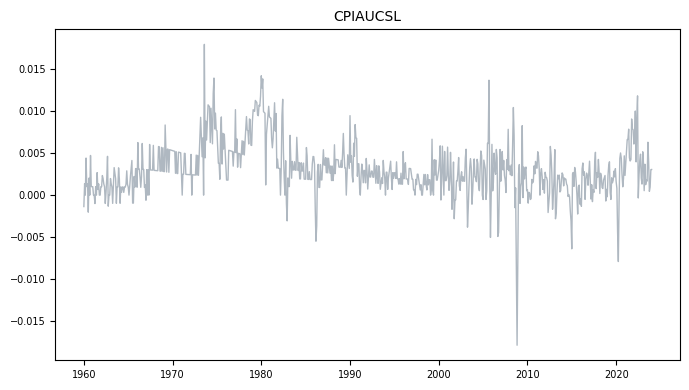

In [21]:
plt.subplots(figsize=(7, 4))
plt.plot(pd.concat([train_dataset[target_name], test_dataset[target_name]]), color="#AFB8C1", lw=1)
plt.tick_params(axis="both", which="major", labelsize=7)
plt.tick_params(axis="both", which="minor", labelsize=7)
plt.legend(bbox_to_anchor=(1, 0, 0, 1), frameon=False, prop={"size": 9})
plt.title(target_name, size=10)
plt.tight_layout()
plt.show()

Run the random forest model.

In [22]:
rf_forecasts = run_random_forest_model(
    params=params,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    target_name=target_name
)

Run the AR(1) model.

In [23]:
ar1_forecasts = run_autoregressive_model(
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    target_name=target_name,
)

Calculate the root mean squared error of the forecasts.

In [24]:
rf_error = root_mean_squared_error(
    y_true=test_dataset[target_name],
    y_pred=rf_forecasts,
)

In [25]:
ar1_error = root_mean_squared_error(
    y_true=test_dataset[target_name],
    y_pred=ar1_forecasts,
)

In [26]:
print(f"RF RMSE: {format(rf_error, '.6f')}")
print(f"AR(1) RMSE: {format(ar1_error, '.6f')}")
print(f"% difference: {format(rf_error / ar1_error - 1, '.3%')}")

RF RMSE: 0.001466
AR(1) RMSE: 0.002027
% difference: -27.669%


Visualize the forecasts.

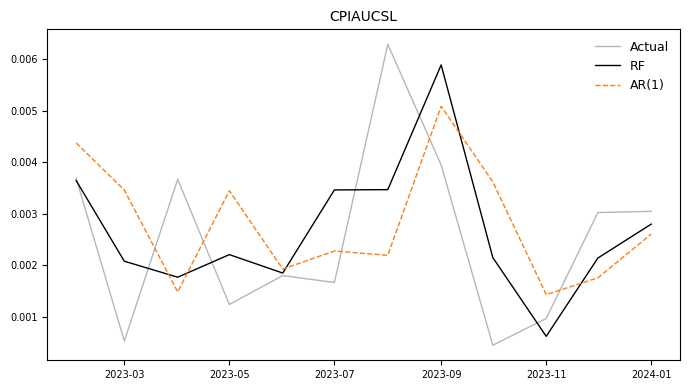

In [27]:
plt.subplots(figsize=(7, 4))
plt.plot(test_dataset[target_name], color="#AFB8C1", lw=1, label="Actual")
plt.plot(rf_forecasts, color="#000000", lw=1, label="RF")
plt.plot(ar1_forecasts, "--", color="#fd7e14", lw=1, label="AR(1)")
plt.tick_params(axis="both", which="major", labelsize=7)
plt.tick_params(axis="both", which="minor", labelsize=7)
plt.legend(bbox_to_anchor=(1, 0, 0, 1), frameon=False, prop={"size": 9})
plt.title(target_name, size=10)
plt.tight_layout()
plt.show()